In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras as kt
from keras.datasets import fashion_mnist

In [2]:
(x_train_or, y_train), (x_test_or, y_test) = fashion_mnist.load_data()

In [3]:
x_train = ((x_train_or / 255) - 0.5) * 2
x_test = ((x_test_or / 255) - 0.5) * 2

In [4]:
plt.set_cmap("gray")

<Figure size 640x480 with 0 Axes>

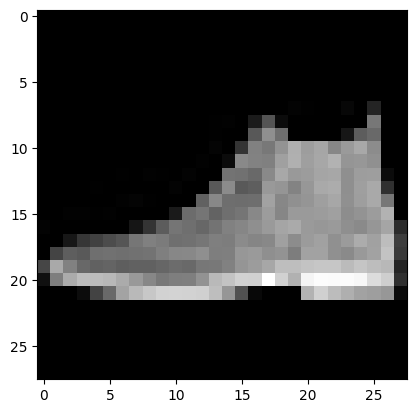

In [5]:
plt.imshow(x_test[0])

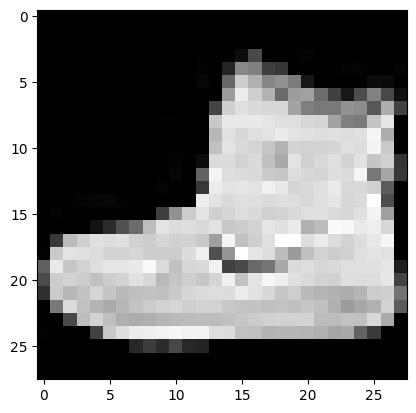

In [6]:
plt.imshow(x_train[0])

In [7]:
# Capas Custom
# 1. Funciones lambda
from keras.layers import Lambda, Input
from keras.models import Model

Square = Lambda(lambda x: x**2)

In [8]:
inp = Input(shape=(2))
# out = Square(inp)
out = Lambda(lambda x: x**2)(inp)
square_model = Model(inp, out)

In [9]:
square_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 lambda_1 (Lambda)           (None, 2)                 0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [10]:
square_model.predict([2])

1/1 [==============================] - 0s 224ms/step


array([4.], dtype=float32)

In [11]:
# Sumar 3 explícitamente

In [12]:
import tensorflow as tf
def sum_3_points(x):
  a, b, c = x[0], x[1], x[2]
  return a + b + c

In [13]:
inp = Input(shape=(3))
out = Lambda(sum_3_points)(inp)
sum_model = Model(inp, out)

In [14]:
sum_model.predict([1,2,3])

1/1 [==============================] - 0s 75ms/step


6.0

In [15]:
# Capas Custom

In [16]:
#  Capa de Sampling

In [17]:
from keras.layers import Layer
class Sampling(Layer):

  def __init__(self):
    super(Sampling, self).__init__()

  def call(self, inputs):
    mu, logstd = inputs
    std = tf.exp(logstd)
    epsilon = tf.random.normal(tf.shape(mu))
    return epsilon * std + mu

In [18]:
mu = Input(shape=2)
logstd = Input(shape=2)
sample = Sampling()([mu, logstd])
sampling_mod = Model([mu, logstd], sample)

In [19]:
sampling_mod.predict([np.array([1., 2.]), np.array([0., -20.])])

1/1 [==============================] - 0s 59ms/step


array([0.2533108, 2.       ], dtype=float32)

In [20]:
from keras.layers.rnn.base_conv_rnn import InputSpec
class KL(Layer):

  def __init__(self, beta=1):
    self.beta = beta
    super(KL, self).__init__()
    

  def call(self, inputs):
    mu, logstd = inputs 
    kl_loss = 0.5 * (tf.square(mu) + tf.exp(logstd * 2.) - 1 - logstd * 2.)
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    self.add_loss(kl_loss)
    return inputs

In [21]:
mu = Input(shape = 2)
logstd = Input(shape = 2)
mu2, logstd2 = KL()([mu, logstd])
kl_model = Model([mu, logstd], [mu2, logstd2])

In [22]:
kl_model.predict([np.array([[1., 2.]]), np.array([[0., 3.]])])

1/1 [==============================] - 0s 45ms/step


[array([[1., 2.]], dtype=float32), array([[0., 3.]], dtype=float32)]

In [23]:
kl_model.compile()

In [24]:
kl_model.evaluate([np.array([[1., 2.]]), np.array([[0., 3.]])], [np.array([[1., 2.]]), np.array([[0., 3.]])])

1/1 [==============================] - 0s 99ms/step - loss: 200.7144


200.7144012451172

In [25]:
# Fin de la capa KL

In [26]:
# Autoencoder

In [27]:
# Clasificador
from keras.layers import Dense, Flatten, Reshape, Input
from keras.models import Sequential, Model

In [28]:
z_dim = 100
h_dim = 200

In [29]:
encoder_head = Sequential([
    Flatten(input_shape = (28,28)),
    Dense(h_dim, activation = 'relu'),
])

inp = Input((28,28))
h = encoder_head(inp)
mu = Dense(z_dim)(h)
logstd = Dense(z_dim)(h)


# KL Layer
muout, logstdout = KL()([mu, logstd])

# Sampling Layer
z = Sampling()([muout,logstdout])

In [30]:
encoder_mean = Model(inp, mu)
encoder_sample = Model(inp, z)

In [31]:
encoder_sample.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 sequential (Sequential)        (None, 200)          157000      ['input_7[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 100)          20100       ['sequential[0][0]']             
                                                                                                  
 dense_2 (Dense)                (None, 100)          20100       ['sequential[0][0]']             
                                                                                            

In [32]:
encoder_sample.predict(x_train[3:4])

1/1 [==============================] - 1s 1s/step


array([[ 1.9158282e+00, -2.8712027e+00,  1.3693424e+00, -6.2949157e+00,
         1.0091186e-02,  4.3029480e+00,  1.0145625e+00, -1.7043390e+00,
        -2.4286218e+00,  5.4372048e-01,  2.4595994e-01,  7.9837894e-01,
        -1.0157318e+01, -8.5921574e-01, -6.3652998e-01, -2.5736628e+00,
         5.2343661e-01,  5.8207688e+00,  9.9688673e-01,  8.1210375e+00,
        -1.3601393e-01, -2.3512788e+00,  9.4738030e-01, -1.4245310e+00,
         4.8581046e-01, -1.2232971e+00, -4.1495168e-01, -1.8138975e-02,
        -1.5019350e+00,  1.1700988e-03, -6.9867826e-01, -5.7398185e-02,
         7.8433889e-01, -2.7653818e+00,  1.8203750e+00,  7.5156558e-01,
         2.7432385e-01,  1.2087598e+00, -1.3132864e+00, -1.3956107e+00,
         4.5463437e-01,  2.4836266e+00,  2.1409762e-01, -7.6204479e-01,
        -8.0582654e-01,  3.6371706e+00,  1.7523688e+00, -4.9157729e+00,
         6.0574818e-01, -1.0756774e+00,  1.3702940e+00,  7.6751566e-01,
        -6.4283216e-01, -5.0043831e+00, -2.0777845e+00, -1.52391

In [33]:
# Decoder

decoder = Sequential([
    Dense(h_dim, activation='relu', input_shape = (z_dim,)),
    Dense(28*28, activation='tanh'),
    Reshape((28,28))
])

In [34]:
vae = Sequential([encoder_mean, decoder])

1/1 [==============================] - 0s 70ms/step


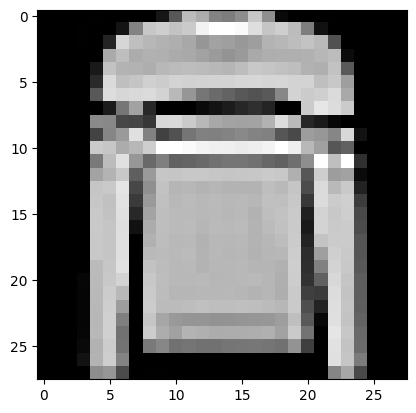

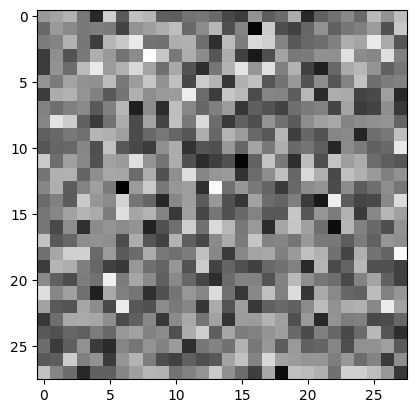

In [35]:
img = 5
plt.imshow(x_train[img])
plt.figure()
plt.imshow(vae.predict(x_train[img:img+1])[0])

In [36]:
from keras.losses import MSE
vae.compile(optimizer = 'adam', loss=lambda x,y: MSE(x,y)*28*28)

In [37]:
n_epochs = 60
batch_size = 128

history = vae.fit(x_train, x_train, validation_data = (x_test, x_test), batch_size=batch_size, epochs=n_epochs)

Epoch 1/60
469/469 [==============================] - 4s 6ms/step - loss: 67.6656 - val_loss: 39.2223
Epoch 2/60
469/469 [==============================] - 3s 6ms/step - loss: 34.3602 - val_loss: 31.1430
Epoch 3/60
469/469 [==============================] - 2s 5ms/step - loss: 28.8614 - val_loss: 27.6193
Epoch 4/60
469/469 [==============================] - 3s 5ms/step - loss: 25.9122 - val_loss: 25.3420
Epoch 5/60
469/469 [==============================] - 3s 7ms/step - loss: 24.0236 - val_loss: 23.4642
Epoch 6/60
469/469 [==============================] - 3s 6ms/step - loss: 22.7170 - val_loss: 22.6636
Epoch 7/60
469/469 [==============================] - 2s 5ms/step - loss: 21.7670 - val_loss: 21.6723
Epoch 8/60
469/469 [==============================] - 2s 5ms/step - loss: 20.9825 - val_loss: 21.1706
Epoch 9/60
469/469 [==============================] - 3s 5ms/step - loss: 20.3940 - val_loss: 20.6810
Epoch 10/60
469/469 [==============================] - 2s 5ms/step - loss: 19.9092

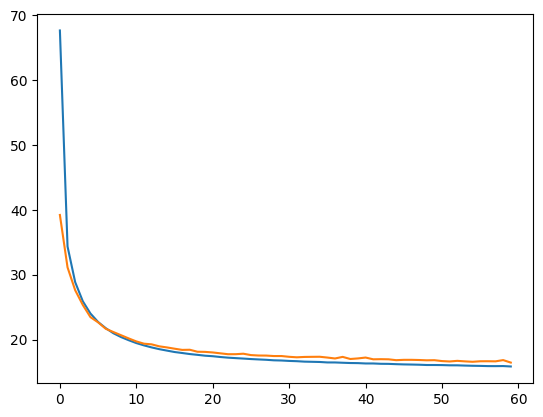

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

1/1 [==============================] - 0s 57ms/step


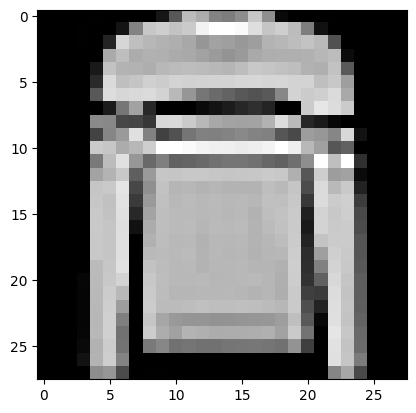

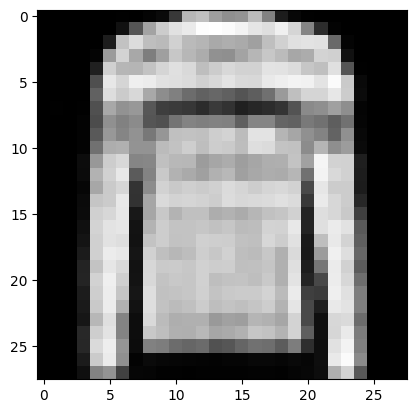

In [39]:
img = 5
plt.imshow(x_train[img])
plt.figure()
plt.imshow(vae.predict(x_train[img:img+1])[0])

Genero uns lista con todos los vectores latentes de los datos de train compilados por el encoder.

In [40]:
# latent_data_list = [encoder_sample.predict(x_train[_]) for _ in trange(len(x_train))]
# latent_data_list_train = [[encoder_mean.predict(x_train[_:_+1])][0] for _ in range(len(x_train))]
# latent_data_list_test = [[encoder_mean.predict(x_test[_:_+1])][0] for _ in range(len(x_test))]

In [41]:
# num = 0
# plt.imshow(x_train[num])
# plt.figure()
# plt.imshow(decoder.predict(latent_data_list_train[num])[0])

In [42]:
# num = 
# plt.imshow(x_test[num])
# plt.figure()
# plt.imshow(decoder.predict(latent_data_list_test[num])[0])

In [43]:
num = 0
latent_train_data = encoder_mean.predict(x_train[num:num+1])[0]
# for num in range(1,len(x_train)):
for num in range(1,5000):
  latent_train_data = np.vstack([latent_train_data, encoder_mean.predict(x_train[num:num+1])[0]])

1/1 [==============================] - 0s 15ms/step


In [45]:
num = 0
latent_test_data = encoder_mean.predict(x_test[num:num+1])[0]
# for num in range(1,len(x_test)):
for num in range(1,5000):
  latent_test_data = np.vstack([latent_test_data, encoder_mean.predict(x_test[num:num+1])[0]])

1/1 [==============================] - 0s 18ms/step


In [46]:
import faiss
d = z_dim  
index = faiss.IndexFlatL2(d)
xb = latent_train_data
xq = latent_test_data
index.add(xb)

In [51]:
num = 
query_pic = xq[num:num+1]
d, i = index.search(query_pic,1) # Quiero buscar el vector más parecido al vector "num" del dataset query en el dataset base. Me dice que el vector más parecido es el 381
print(i[0])
similar_pic = latent_test_data[i[0]]

[513]


1/1 [==============================] - 0s 17ms/step


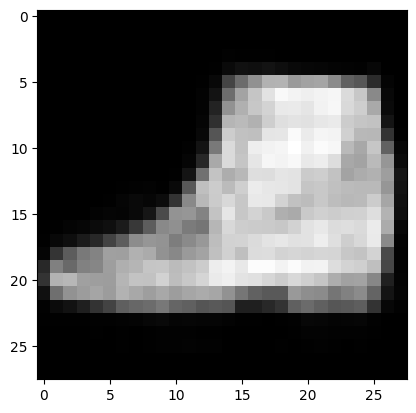

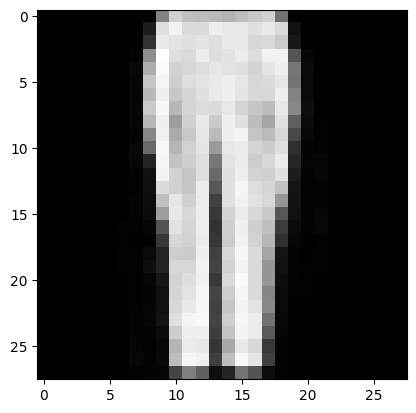

In [52]:
plt.imshow(decoder.predict(query_pic)[0])
plt.figure()
plt.imshow(decoder.predict(similar_pic)[0])